<a href="https://colab.research.google.com/github/theKirill/RecognitionOfRoadSigns/blob/master/CourseWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

In [0]:
import numpy as np

In [0]:
from skimage import io, transform

In [0]:
import matplotlib.pyplot as plt

In [0]:
import pandas as pd

In [0]:
from PIL import Image, ImageDraw

In [0]:
import cv2

In [10]:
import keras 

Using TensorFlow backend.


In [0]:
from keras.models import Sequential 

In [0]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [0]:
from keras.utils import to_categorical

In [0]:
from keras.callbacks import ModelCheckpoint

In [0]:
from keras.models import load_model

In [0]:
IMG_SIZE = 32 #размер изображения

In [0]:
CLASSES_COUNT = 30

In [0]:
class RoadSignLocalization:
  def __init__(self):
    self.__path_images = "" #путь, где хранятся изображения
    self.__extension_images = ".ppm" #расширения изображений
    
  @property
  def path_images(self):
    return self.__path_images

  @path_images.setter
  def path_images(self, path):
    self.__path_images = path

  @property
  def extension_images(self):
    return self.__path_images

  @path_images.setter
  def extension_images(self, extension):
    self.__extension_images = extension

  # Получение всех содержащихся обучающих изображений знаков и номеров классов этих знаков
  def get_all_train_images(self):
    self.__path_images = "drive/My Drive/Images_Train2/"
    images_of_signs = []
    classes_of_signs = []

    for root, dirs, files in os.walk(self.__path_images):
      sign_class = root[-2:]
      if sign_class.isdigit():
        name_csv = root + "/GT-000" + sign_class + ".csv"
        file_csv = pd.read_csv(name_csv, delimiter = ';')
        #Берём углы знаков для каждого изображения из csv файла
        x_left = file_csv['Roi.X1']
        y_left = file_csv['Roi.Y1']
        x_right = file_csv['Roi.X2']
        y_right = file_csv['Roi.Y2']
        i = 0
        for file in files: #каждое изображение обрезаем по области знака, масштабируем до 32*32
          if file[-4:] == self.__extension_images:
            self.get_sign_area(root +'/', file, y_left[i], y_right[i], x_left[i], x_right[i])
            self.scale_img(root + '/', file[:-4] + "_new.ppm")
            images_of_signs.append(io.imread(root + '/' + file[:-4] + "_new.ppm"))#добавляем в массив изображений
            classes_of_signs.append(int(sign_class))#заносим информацию о классе знака
            i+=1
    
    images_of_signs = np.array(images_of_signs, dtype = "float32") / 255.0
    classes_of_signs = to_categorical(classes_of_signs, CLASSES_COUNT)

    return images_of_signs, classes_of_signs

  # Получение всех тестовых изображений знаков и номеров классов этих знаков
  def get_all_test_images(self):
    self.__path_images = "drive/My Drive/Images_Test2/"
    images_of_signs = []
    classes_of_signs = []

    file_csv = pd.read_csv(self.__path_images + '_GT-final_test.csv', delimiter=';') #читаем информацию о каждом изображении
    #Берём углы и классы знаков для каждого изображения из csv файла
    images_names = file_csv['Filename']
    x_left = file_csv['Roi.X1']
    y_left = file_csv['Roi.Y1']
    x_right = file_csv['Roi.X2']
    y_right = file_csv['Roi.Y2']
    self.__classes_of_signs = file_csv["ClassId"]

    for i in range(images_names.size):#каждое изображение обрезаем по области знака, масштабируем до 32*32
      self.get_sign_area(self.__path_images, images_names[i], y_left[i], y_right[i], x_left[i], x_right[i])
      self.scale_img(self.__path_images, images_names[i][:-4] + "_new.ppm")
      self.__images_of_signs.append(io.imread(self.__path_images + images_names[i][:-4] + "_new.ppm"))

    images_of_signs = np.array(images_of_signs, dtype = "float32") / 255.0
    classes_of_signs = to_categorical(classes_of_signs, CLASSES_COUNT)

    return images_of_signs, classes_of_signs

  # Получение всех изображений знаков для предсказания классов
  def get_all_signs_for_predict(self):
    self.__path_images = "drive/My Drive/BadSigns/"
    new_root = "drive/My Drive/GoodSigns/"
    images_of_signs = []
    names_of_images = []

    for root, dirs, files in os.walk(self.__path_images):
      for file in files:
        img = io.imread(root + file)
        hsv = self.to_hsv(img)
        mask = self.binarization(hsv)
        mask = self.canny(mask)

        contours = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) #находим контуры
        contours = contours[1] #берём только массив контуров

        if contours:
          contours = sorted(contours, key = cv2.contourArea, reverse = True)#сортируем контуры по площади
          (x,y,w,h) = cv2.boundingRect(contours[0]) #вырезаем прямоугольную область самого большого контура, получаем координаты его верхнего левого угла и ширину/высоту

          # обрезаем знак по прямоугольнику, масштабируем
          self.get_sign_area(root, file, y, y + h, x, x + w, new_root)      
          self.scale_img(new_root, file)
          images_of_signs.append(io.imread(new_root + file))
          names_of_images.append(file)
    
    images_of_signs = np.array(images_of_signs, dtype = "float32") / 255.0
    names_of_images = np.array(names_of_images)

    return images_of_signs, names_of_images

  #"Вырезаем" область знака
  def get_sign_area(self, root, name_img, y_left, y_right, x_left, x_right, new_root = ""):
    img = cv2.imread(root + name_img)
    # Обрезаем изображение по прямоугольнику
    area_sign = img[y_left:y_right, x_left:x_right]

    if new_root == "":
      cv2.imwrite(root + name_img[:-4] + "_new." + name_img[-3:], area_sign)
    else:
      cv2.imwrite(new_root + name_img, area_sign)

  #Масштабируем изображение до 32*32
  def scale_img(self, root, name_img):
    basewidth = 300
    img = Image.open(root + name_img)

    draw = ImageDraw.Draw(img)  # Создаем инструмент для рисования.
    width = img.size[0]  # Определяем ширину.
    height = img.size[1]  # Определяем высоту.
    pix = img.load()  # Выгружаем значения пикселей.

    wpercent = (basewidth / float(img.size[0]))
    # Масштабируем до нужного размера
    img = img.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
    img.save(root + name_img)

  # перевод изображения в HSV-формат
  def to_hsv(self, img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  # Ищем с помощью детектора Canny края объектов
  def canny(self, img):
    return cv2.Canny(img, 100, 200, apertureSize = 7)
  
  # бинаризация изображения по красному цвету
  def binarization_red(self, img):
    return cv2.inRange(img, (117,100,45), (255,255,255))
  
  # бинаризация изображения по синему цвету
  def binarization_blue(self, img):
    return cv2.inRange(img, (0, 175, 40), (25, 255, 255))#cv2.inRange(img, (117,100,45), (255,255,255))#cv2.inRange(sss, (0, 225, 0), (50, 255, 255))

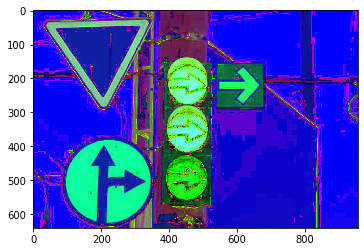

In [722]:
localization = RoadSignLocalization()
sss = localization.to_hsv(io.imread("drive/My Drive/BadSigns/sign_right_straight.jpg"))
plt.imshow(sss)

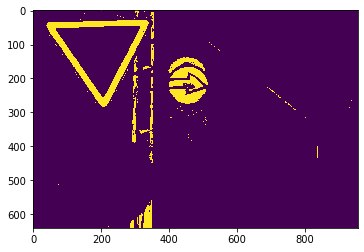

In [723]:
ssss2 = cv2.inRange(sss, (117,100,45), (255,255,255))
plt.imshow(ssss2)

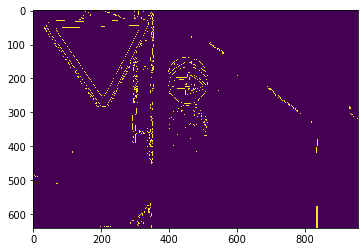

In [724]:
ssss2=cv2.Canny(ssss2,100,200,apertureSize=7) #Ищем с помощью детектора Canny края объектов
plt.imshow(ssss2)

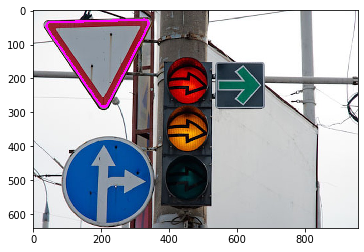

In [725]:
contours = cv2.findContours(ssss2,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) #находим контуры
contours = contours[1] #берём только массив контуров
contours = sorted(contours, key=cv2.contourArea, reverse=True)
fram =io.imread("drive/My Drive/BadSigns/sign_right_straight.jpg")
cv2.drawContours(fram, contours[0], -1, (255, 0, 255), 5)
plt.imshow(fram)

39 27 301 257


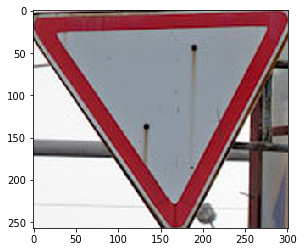

In [726]:
#kkk = np.array(kkk)
(x,y,w,h)=cv2.boundingRect(contours[0])
print(x,y,w,h)
kek=io.imread("drive/My Drive/BadSigns/sign_right_straight.jpg")
area_sign = kek[y:y+h,x:x+w]
plt.imshow(area_sign)

In [0]:
class RoadSignClassification:
  def __init__(self):
    self.__EPOCHS_COUNT = 50
    self.__BATCH_SIZE = 200
    self.__X_train = []
    self.__y_train = []
    self.__X_test = []
    self.__y_test = []
    self.__history = []
    self.__X_predict = []
    self.__names_of_images = []

  @property
  def EPOCHS_COUNT(self):
    return self.__EPOCHS_COUNT

  @EPOCHS_COUNT.setter
  def EPOCHS_COUNT(self, count):
    self.__EPOCHS_COUNT = count

  @property
  def BATCH_SIZE(self):
    return self.__BATCH_SIZE

  @BATCH_SIZE.setter
  def BATCH_SIZE(self, size):
    self.__BATCH_SIZE = size

  def get_model(self):
    model = Sequential() # Создание модели
    model.add(Conv2D(32, (3, 3), input_shape = (IMG_SIZE, IMG_SIZE, 3), padding = 'same', activation = 'relu'))
    
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))

    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding = 'same', activation = 'relu'))
    
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())

    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(CLASSES_COUNT, activation = 'softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  
    return model

  # обучаем модель
  def fit_model(self):
    self.prepocess_train_images()
    my_model = self.get_model()
    self.__history = my_model.fit(self.__X_train, self.__y_train, epochs = self.__EPOCHS_COUNT, batch_size = self.__BATCH_SIZE, validation_split = 0.1,
         callbacks=[ModelCheckpoint('drive/My Drive/Models/modelBest_december.h5', save_best_only = True)])
    
  # подготавливаем изображения для обучения
  def prepocess_train_images(self):
    localization = RoadSignLocalization()
    self.__X_test, self.__y_test = localization.get_all_train_images()

  # тестируем сеть на тестовых изображениях из базы
  def test_model(self):
    self.prepocess_test_images()
    trained_model = self.get_trained_model()
    prediction = trained_model.predict_classes(self.__X_test)
    return np.sum(prediction == self.__y_test) / np.size(prediction) 

  # подготавливаем изображения для теста
  def prepocess_test_images(self):
    localization = RoadSignLocalization()
    self.__X_test, self.__y_test = localization.get_all_test_images()

  # получаем ранее обученную модель  
  def get_trained_model(self):
    model = load_model('drive/My Drive/Models/modelBest03_11(11).h5')#modelBest03_11(11)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

  # предсказываем классы знаков на своих изображениях
  def predict_classes(self):
    names_classes = ['Ограничение скорости (20)','Ограничение скорости (30)','Ограничение скорости (50)',
                 'Ограничение скорости (60)','Ограничение скорости (70)','Ограничение скорости (80)',
                 'Ограничение скорости (100)','Ограничение скорости (120)','Обгон запрещён',
                 'Главная дорога','Уступите дорогу','Знак STOP','Движение запрещено','Въезд запрещён',
                 'Крутой поворот налево','Крутой поворот направо','Опасные повороты','Неровная дорога',
                 'Скользкая дорога','Сужение дороги справа','Ремонт дороги','','Осторожно, пешеходы',
                 'Отмена всех ограничений','Поворот только направо','Поворот только налево','Движение только прямо',
                 'Движение прямо и направо','Движение прямо и налево','Круговое движение']
    
    self.prepocess_images_for_predict()
    trained_model = self.get_trained_model()

    prediction = trained_model.predict_classes(self.__X_predict)

    for i in range(self.__X_predict.shape[0]):
      print("Изображение '{}' содержит знак - {}".format(self.__names_of_images[i], names_classes[prediction[i]]))

  # подготавливаем изображения для предсказания классов
  def prepocess_images_for_predict(self):
    localization = RoadSignLocalization()
    self.__X_predict, self.__names_of_images = localization.get_all_signs_for_predict()

In [0]:
classification = RoadSignClassification()

In [229]:
classification.predict_classes()

Изображение 'sign30.jpg' содержит знак - Ограничение скорости (30)
Изображение 'sign20.jpg' содержит знак - Ограничение скорости (20)
Изображение 'sign_въезд_запрещён.jpg' содержит знак - Въезд запрещён
Изображение 'sign_no_drive.jpg' содержит знак - Движение запрещено
Изображение 'sign_humans.jpg' содержит знак - Осторожно, пешеходы
Изображение 'sign_right_straight.jpg' содержит знак - Уступите дорогу
Изображение 'sign50.jpg' содержит знак - Ограничение скорости (50)
Изображение 'sign_опасные_повороты.jpg' содержит знак - Опасные повороты
Изображение 'sign80.jpg' содержит знак - Ограничение скорости (80)
Изображение 'sign_уступите_road2.jpg' содержит знак - Уступите дорогу
Изображение 'sign_обгон_запрещен.jpg' содержит знак - Обгон запрещён
Изображение 'sign_крутой_поворот_право.jpg' содержит знак - Крутой поворот направо
Изображение 'sign_круговое_движение.jpg' содержит знак - Уступите дорогу
Изображение 'sign_stop.jpg' содержит знак - Знак STOP
Изображение 'sign_right_straight_new